In [201]:
# Dependencies
import tweepy
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.font_manager import FontProperties


from datetime import datetime
from datetime import timedelta
import TwitterAPIKeys
import csv

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [202]:
# Twitter API Keys
consumer_key = TwitterAPIKeys.consumer_key
consumer_secret = TwitterAPIKeys.consumer_secret
access_token = TwitterAPIKeys.access_token
access_token_secret = TwitterAPIKeys.access_token_secret 

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [203]:
# Set up lists for the News Outlet Twitter handles and names (to be used in the dataframe and plots)
# Here we are also setting the colors for the outlets so that both the plots look consistent.
News_Outlets = ["@BBC", "@CBS", "@CNN","@foxnews","@nytimes"]
OutletLables = ["BBC", "CBS", "CNN","Fox","NYT" ]
colors = ['lightblue', 'green', 'red','blue','black']


In [204]:
#Set up the dataframe for capturing the outlet, tweet, time stamp and sentiment analysis.

FinalTweetDf = pd.DataFrame() # holds all the 500 tweets

# Loop through all news outlets
for outlet in News_Outlets:
    
    public_tweets = api.user_timeline(outlet, count=100, result_type="recent") # Get the 100 recent tweets
    NewsOutlet = OutletLables[News_Outlets.index(outlet)] # Converting the twitter handle to a the news outlet name.
    
    newsOutletTweetDf = pd.DataFrame() # empty dataframe to  hold all the 100 tweets per News Outlet
    
        # Loop through all tweets
    for tweet in public_tweets:
        tweetContent = tweet["text"]
        #VADER sentiment Alaysis
        scores =analyzer.polarity_scores(tweet["text"])
            
        #Formatting the created_at
        dateStamp = tweet['created_at']
        clean_timestamp = datetime.strptime(dateStamp,'%a %b %d %H:%M:%S +0000 %Y')
        offset_hours = -5 #offset in hours for EST timezone

        #account for offset from UTC using timedelta                                
        local_timestamp = clean_timestamp + timedelta(hours=offset_hours)

        #convert to am/pm format for easy reading
        final_timestamp =  datetime.strftime(local_timestamp, 
                    '%Y-%m-%d %I:%M:%S %p')  
            
        # ADD the above data to a temporary dataframe that will be appended to newsOutletTweetDf
        tempDf = pd.DataFrame({'NewsOutlet':NewsOutlet,
                                   'Tweet': tweetContent,
                                   'Timestamp': final_timestamp,
                                   'CompoundScore': scores["compound"],
                                   'PositiveScore': scores["pos"],
                                   'NeutralScore' : scores["neu"],
                                   'NegativeScore': scores["neg"]}, index = [0])
        
        newsOutletTweetDf = newsOutletTweetDf.append(tempDf, ignore_index = True) # Collecting all the tweets per newsoutlet
        
     #Sort the dataframe by the timestamp and assign values (0 to 99) to TweetAgo
     #for the relative tweet timings accross the news outlet
        
    newsOutletTweetDf = newsOutletTweetDf.sort_values("Timestamp") 
    newsOutletTweetDf = newsOutletTweetDf.reset_index(drop=True)
    newsOutletTweetDf["TweetAgo"] = newsOutletTweetDf.index
    
    #Append the newsOutletTweetDf to the FinalTweetDf
    
    FinalTweetDf = FinalTweetDf.append(newsOutletTweetDf,ignore_index = True)
    

#Writing tweets and the results of the Sentiment analysis into a CSV
FinalTweetDf.to_csv("TweetsAnalyzed.csv")

# Get today's date to be used for the plots
Today_Date=  pd.to_datetime('today').strftime("%m/%d/%Y")

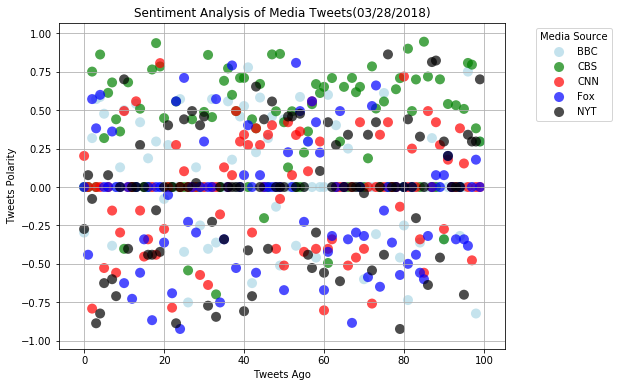

In [205]:
# Chart 1 : Scatter plot of sentiments of the last 100 tweets sent out by each news organization
fig = plt.figure(figsize = (8,6))
plt.grid(axis = 'both')

#Create your Newsoutlet groups for tweets

NewsOutletGrpings =[]

for NewsOutlet in OutletLables:
    NewsOutletGroup = FinalTweetDf.loc[FinalTweetDf['NewsOutlet']==NewsOutlet]
    NewsOutletGrpings.append(NewsOutletGroup)

for data, color, outletlable in zip(NewsOutletGrpings, colors, OutletLables):  
    plt.scatter(data['TweetAgo'],data['CompoundScore'],marker ='o',
                s=100, alpha=0.7, c=color, edgecolors='none', label=outletlable)
    
#Formatting the legend
from matplotlib.font_manager import FontProperties
lgnd = plt.legend(title = 'Media Source', scatterpoints=1, fontsize=10,bbox_to_anchor=(1.25, 1), ncol=1)
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
lgnd.legendHandles[2]._sizes = [100]
lgnd.legendHandles[3]._sizes = [100]
lgnd.legendHandles[4]._sizes = [100]

plt.title(f"Sentiment Analysis of Media Tweets({Today_Date})" )
        
plt.xlabel("Tweets Ago")
plt.ylabel("Tweets Polarity")

plt.show() 




In [206]:
# Set up a dataframe for the over all sentiment analysis
OverAllSentimentDF = FinalTweetDf.groupby("NewsOutlet").agg({'CompoundScore':['mean']})
OverAllSentimentDF.reset_index(inplace = True)
OverAllSentimentDF.columns=[''.join(col) for col in OverAllSentimentDF.columns ]
OverAllSentimentDF = OverAllSentimentDF.rename(columns = {'CompoundScoremean': 'Overall Sentiment'})
OverAllSentimentDF.head()

,NewsOutlet,Overall Sentiment
0,BBC,0.049669
1,CBS,0.353884
2,CNN,-0.020635
3,Fox,-0.075833
4,NYT,-0.039319


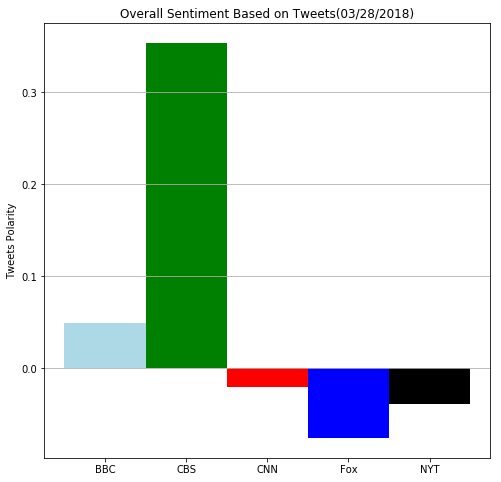

In [207]:
# Chart 2: Overall sentiments of the last 100 tweets from each organization

fig = plt.figure(figsize = (8,8))
plt.grid(axis = 'y')
x_axis = np.arange(len(OverAllSentimentDF))
tick_locations = [value for value in x_axis]

plt.xticks(tick_locations,OverAllSentimentDF['NewsOutlet'])

#for data, color, outletlable in zip(OverAllSentimentDF, colors, OutletLables):  
#plt.bar(x=data['NewsOutlet'],y = data['Overall Sentiment'],label=outletlable)
plt.title(f"Overall Sentiment Based on Tweets({Today_Date})" )
plt.ylabel("Tweets Polarity")
plt.bar(x_axis, OverAllSentimentDF['Overall Sentiment'], color = colors,align='center', width = 1)
plt.show()  